# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

- Data was collected from 17 marketing campaigns conducted by a Portuguese bank between May 2008 and November 2010, totaling 79,354 contacts with an 8% success rate. ​
- The dataset included 59 attributes related to client and contact information. ​
- The rminer library in R was used for data mining analysis. 

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [2]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score

from sklearn.decomposition import PCA

In [3]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [4]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



#### Missing Values:
Several features include the category 'unknown' which likely represents missing or unavailable data. These entries should be treated as missing values during processing and we might have to impute (eg. mean or most frequent value) or drop the rows.
- job
- material
- education
- default
- housing
- loan

#### Data Type Coerced:
| Feature | Expected Data Type | Notes |
|:---|:---|:---|
| age | Numeric | No Change |
| job, material, education, default,<br>housing, loan, contact, month,<br>day_of_week, poutcome, y | Categorical | Convert to category or one-hot encode |
| duration, campaign, pdays,<br>previous, emp.var.rate, cons.price.idx,<br>cons.conf.idx, euribor3m, nr.employed | Numeric | No Change |

#### Considerations:
- pdays: value 999 is a placeholder for not previously contacted, so it may need to be handled separately.
- duration: need to be excluded from the predictive model

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.



In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

#### Business Objective:
The primary business objective is to predict whether a customer will subscribe to a term deposit (y column: 'yes' or 'no') based on their personal, financial, and interaction-related attributes. This helps the bank:

- Optimize marketing efforts
- Target the right customers
- Improve campaign efficiency
- Increase conversion rates

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [10]:
# Drop target column
X = df.drop('y', axis=1)

# Binary encoding for Target Column
y = df['y'].map({'yes': 1, 'no': 0})

In [12]:
# Drop column duration
X = X.drop('duration', axis=1)

In [14]:
# Replace 'unknown' with NaN
X.replace('unknown', np.nan, inplace=True)

# Create binary feature for previous contact
X['was_previously_contacted'] = (X['pdays'] != 999).astype(int)

# Optional: drop 'pdays' if you prefer the binary version
# X.drop('pdays', axis=1, inplace=True)

# Identify column types
cat_cols = X.select_dtypes(include='object').columns
num_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Define preprocessing pipelines
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Combine into column transformer
preprocessor = ColumnTransformer([
    ('cat', cat_pipeline, cat_cols),
    ('num', num_pipeline, num_cols)
], verbose_feature_names_out=False)

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [16]:
# Split the data into Train & Test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [18]:
#baseline_accuracy = y.value_counts().max() / len(y)

#dummy_clf = DummyClassifier().fit(X_train, y_train)
#baseline_score = dummy_clf.score(X_test, y_test)

# Define dummy classifier pipeline
baseline_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('dummyclassifier', DummyClassifier(strategy='most_frequent'))
])

# Fit and evaluate
baseline_pipeline.fit(X_train, y_train)
baseline_score = baseline_pipeline.score(X_test, y_test)

print(f"Baseline Accuracy (DummyClassifier): {baseline_score:.4f}")

Baseline Accuracy (DummyClassifier): 0.8874


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [20]:
# Initialize Logistic Regression model pipeline
lr_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('lrmodel', LogisticRegression())
])

# Fit and evaluate
lr_pipeline.fit(X_train, y_train)

# Predict on test set
y_pred = lr_pipeline.predict(X_test)

### Problem 9: Score the Model

What is the accuracy of your model?

In [22]:
# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Accuracy: {accuracy:.4f}")

# Detailed performance report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

#print("\nConfusion Matrix:")
#print(confusion_matrix(y_test, y_pred))

Logistic Regression Accuracy: 0.9013

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      7310
           1       0.69      0.22      0.34       928

    accuracy                           0.90      8238
   macro avg       0.80      0.60      0.64      8238
weighted avg       0.88      0.90      0.88      8238



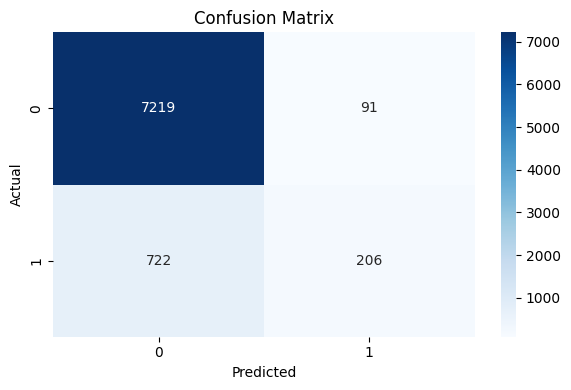

In [24]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot using seaborn heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [26]:
results = []

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "SVM": SVC()
}

In [28]:
# Train and evaluate each model with preprocessing
for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessing', preprocessor),
        ('model', model)
    ])
    
    start = time.time()
    pipeline.fit(X_train, y_train)
    train_time = time.time() - start
    train_acc = pipeline.score(X_train, y_train)
    test_acc = pipeline.score(X_test, y_test)
    
    results.append({
        "Model": name,
        "Train Time": round(train_time, 4),
        "Train Accuracy": round(train_acc, 4),
        "Test Accuracy": round(test_acc, 4)
    })

# Create DataFrame
results_df = pd.DataFrame(results)
print(results_df)

                 Model  Train Time  Train Accuracy  Test Accuracy
0  Logistic Regression      0.3936          0.8999         0.9013
1                  KNN      0.0871          0.9130         0.8931
2        Decision Tree      0.2157          0.9948         0.8455
3                  SVM     34.4841          0.9044         0.9035


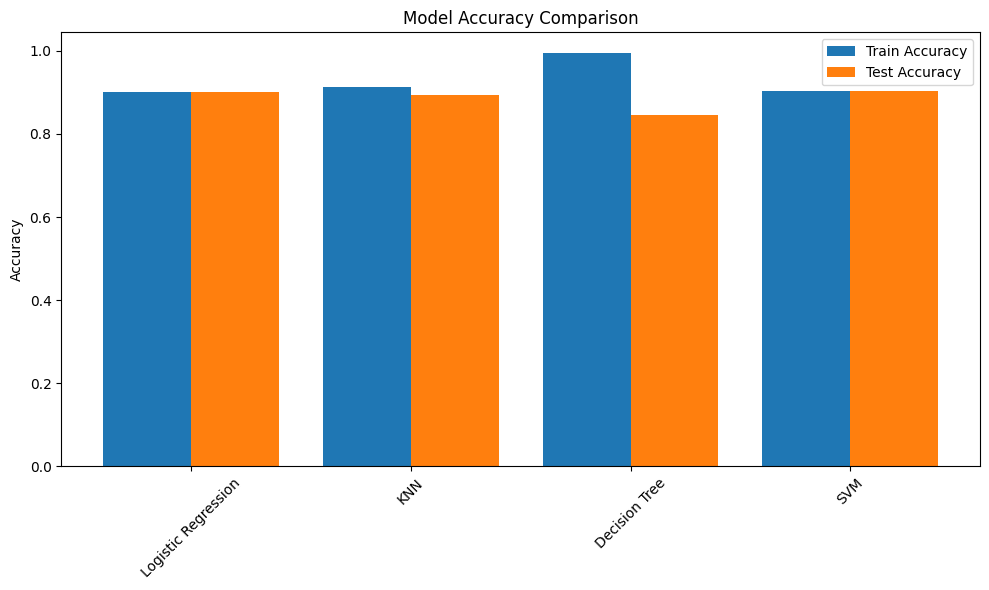

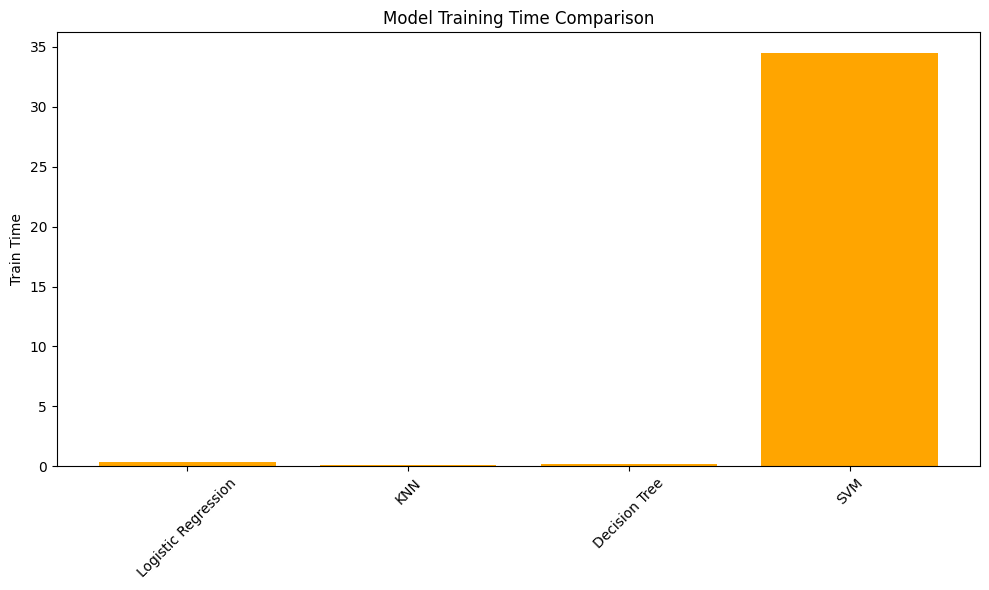

In [29]:
# Accuracy comparison
plt.figure(figsize=(10, 6))
x = range(len(results_df["Model"]))
plt.bar(x, results_df["Train Accuracy"], width=0.4, label="Train Accuracy", align='center')
plt.bar([i + 0.4 for i in x], results_df["Test Accuracy"], width=0.4, label="Test Accuracy", align='center')
plt.xticks([i + 0.2 for i in x], results_df["Model"], rotation=45)
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.legend()
plt.tight_layout()
plt.show()

# Train time comparison
plt.figure(figsize=(10, 6))
plt.bar(results_df["Model"], results_df["Train Time"], color='orange')
plt.ylabel("Train Time")
plt.title("Model Training Time Comparison")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

Original shape: (41188, 20)
Transformed shape: (41188, 21)
Explained variance ratio: [0.30865446 0.14385662 0.08487637 0.07143658 0.06503221 0.04249075
 0.03648647 0.02643059 0.02070924 0.01814892 0.01767132 0.01650278
 0.01532458 0.01487357 0.01431722 0.01411054 0.01200107 0.00920675
 0.00859097 0.00723214 0.00602756]


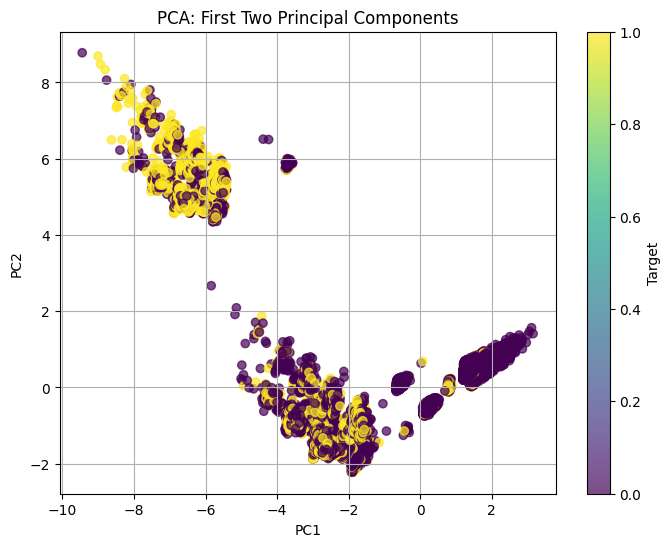

In [30]:
# Define the pipeline
pca_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('pca', PCA(n_components=0.95, svd_solver='full'))
])

# Fit the pipeline
pca_pipeline.fit(X)

# Transform the data
X_pca = pca_pipeline.transform(X)

# Print summary
print("Original shape:", X.shape)
print("Transformed shape:", X_pca.shape)
print("Explained variance ratio:", pca_pipeline.named_steps['pca'].explained_variance_ratio_)

# Optional: Visualize the first two principal components
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.7)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA: First Two Principal Components')
plt.colorbar(label='Target')
plt.grid(True)
plt.show()

In [31]:
results = []

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "SVM": SVC()
}

In [32]:
# Train and evaluate each model with preprocessing
for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessing', preprocessor),
        ('pca', PCA(n_components=0.95, svd_solver='full')),
        ('model', model)
    ])
    
    start = time.time()
    pipeline.fit(X_train, y_train)
    train_time = time.time() - start
    train_acc = pipeline.score(X_train, y_train)
    test_acc = pipeline.score(X_test, y_test)
    #cv_scores = cross_val_score(pipeline, X, y, cv=5)
    y_pred = pipeline.predict(X_test)
    
    results.append({
        "Model": name,
        "Train Time": round(train_time, 4),
        "Train Accuracy": round(train_acc, 4),
        "Test Accuracy": round(test_acc, 4),
        #"CV Scores": round(cv_scores, 4),
        #"y Pred": y_pred
    })

# Create DataFrame
results_df = pd.DataFrame(results)
print(results_df)

                 Model  Train Time  Train Accuracy  Test Accuracy
0  Logistic Regression      0.1388          0.8999         0.9011
1                  KNN      0.1555          0.9120         0.8932
2        Decision Tree      1.5056          0.9948         0.8441
3                  SVM     20.5101          0.9021         0.9012


### Hyperparameter tuning

In [40]:
# Define pipeline for LogisticRegression
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('pca', PCA(n_components=0.95)),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Define parameter grid
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__penalty': ['l2'],
    'classifier__solver': ['liblinear', 'saga', 'lbfgs']
}

# Grid search with 5-fold cross-validation
lr_grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit
lr_grid_search.fit(X_train, y_train)

# Best results
print("Best Parameters:", grid_search.best_params_)
print("Best CV Score:", round(lr_grid_search.best_score_, 4))
print("Test Accuracy:", round(lr_grid_search.score(X_test, y_test), 4))

Best Parameters: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best CV Score: 0.9
Test Accuracy: 0.9008


In [56]:
# Feature Importance using coef
feature_names = pipeline.named_steps['preprocessing'].get_feature_names_out()

pca = lr_grid_search.best_estimator_.named_steps['pca']
loadings = pd.DataFrame(pca.components_.T, 
                        columns=[f'PC{i+1}' for i in range(pca.n_components_)],
                        index=feature_names)

classifier = lr_grid_search.best_estimator_.named_steps['classifier']
pc_weights = classifier.coef_[0]  # For binary classification

feature_importance = loadings @ pc_weights
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

print(importance_df.sort_values(by='Importance', ascending=False))


                                                     Feature  Importance
month_jul                                          month_jul    0.324063
cons.price.idx                                cons.price.idx    0.172962
was_previously_contacted            was_previously_contacted    0.164737
month_jun                                          month_jun    0.142902
day_of_week_wed                              day_of_week_wed    0.135178
month_aug                                          month_aug    0.115667
education_university.degree      education_university.degree    0.113397
cons.conf.idx                                  cons.conf.idx    0.079991
poutcome_nonexistent                    poutcome_nonexistent    0.073862
marital_single                                marital_single    0.059123
month_oct                                          month_oct    0.053137
month_sep                                          month_sep    0.049554
day_of_week_tue                              day_of

In [58]:
# Define pipeline for KNeighborsClassifier
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('pca', PCA(n_components=0.95)),
    ('classifier', KNeighborsClassifier())
])

# Define parameter grid
param_grid = {
    'classifier__n_neighbors': list(range(3, 16)),
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan']
}

# Grid search with 5-fold cross-validation
knn_grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit
knn_grid_search.fit(X_train, y_train)

# Best results
print("Best Parameters:", knn_grid_search.best_params_)
print("Best CV Score:", round(knn_grid_search.best_score_, 4))
print("Test Accuracy:", round(knn_grid_search.score(X_test, y_test), 4))

Best Parameters: {'classifier__metric': 'euclidean', 'classifier__n_neighbors': 12, 'classifier__weights': 'uniform'}
Best CV Score: 0.8964
Test Accuracy: 0.8966


In [60]:
# Define pipeline for DecisionTreeClassifier
pipeline = Pipeline([
    ('preprocessing', preprocessor),
#    ('pca', PCA(n_components=0.95)),
    ('classifier', DecisionTreeClassifier())
])

# Define parameter grid
param_grid = {
    'classifier__max_depth': range(3, 21),
    'classifier__min_samples_split': range(2, 11),
    'classifier__min_samples_leaf': range(1, 6),
    'classifier__criterion': ['gini', 'entropy']
}

# Grid search with 5-fold cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit
grid_search.fit(X_train, y_train)

# Best results
print("Best Parameters:", grid_search.best_params_)
print("Best CV Score:", round(grid_search.best_score_, 4))
print("Test Accuracy:", round(grid_search.score(X_test, y_test), 4))

/opt/anaconda3/envs/openAI/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 3, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
Best CV Score: 0.8994
Test Accuracy: 0.9007


In [62]:
# Define pipeline for SVC
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('pca', PCA(n_components=0.95)),
    ('classifier', SVC())
])

# Define parameter grid
param_grid = {
    'classifier__C': [0.1, 1.0, 10.0, 100.0],
    #'classifier__kernel': ['linear', 'rbf', 'poly'],
    'classifier__kernel': ['rbf'],
    #'classifier__gamma': ['scale', 'auto']
    'classifier__gamma': ['scale']
}

# Grid search with 5-fold cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit
grid_search.fit(X_train, y_train)

# Best results
print("Best Parameters:", grid_search.best_params_)
print("Best CV Score:", round(grid_search.best_score_, 4))
print("Test Accuracy:", round(grid_search.score(X_test, y_test), 4))

Best Parameters: {'classifier__C': 0.1, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}
Best CV Score: 0.8993
Test Accuracy: 0.9001


### Evaluate Models using best parameters

In [64]:
# Initialize list to store results
results = []

# Define models and names
models = {
    "Logistic Regression": LogisticRegression(C=0.1, penalty='l2', solver='liblinear'),
    "KNN": KNeighborsClassifier(n_neighbors=12, weights='uniform', metric='euclidean'),
    "Decision Tree": DecisionTreeClassifier(criterion='gini', max_depth=3, min_samples_leaf=1, min_samples_split=2),
    "SVM": SVC(C=0.1, kernel='rbf', gamma='scale')
}

# Loop through models
for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessing', preprocessor),
        ('classifier', model)
    ])
    
    start = time.time()
    pipeline.fit(X_train, y_train)
    end = time.time()
    
    train_acc = pipeline.score(X_train, y_train)
    test_acc = pipeline.score(X_test, y_test)
    
    results.append({
        "Model": name,
        "Train Time": round(end - start, 4),
        "Train Accuracy": round(train_acc, 4),
        "Test Accuracy": round(test_acc, 4)
    })

# Create DataFrame
df_results = pd.DataFrame(results)
print(df_results)

                 Model  Train Time  Train Accuracy  Test Accuracy
0  Logistic Regression      0.1846          0.8998         0.9016
1                  KNN      0.0823          0.9046         0.8972
2        Decision Tree      0.1155          0.8997         0.9007
3                  SVM     15.2067          0.8994         0.9002


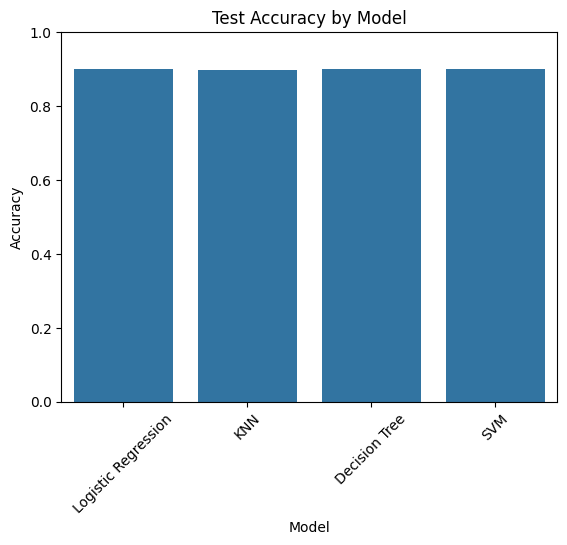

In [66]:
# Bar chart of test accuracy
sns.barplot(data=df_results, x="Model", y="Test Accuracy")
plt.title("Test Accuracy by Model")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.show()

### Adjust Performance metrics

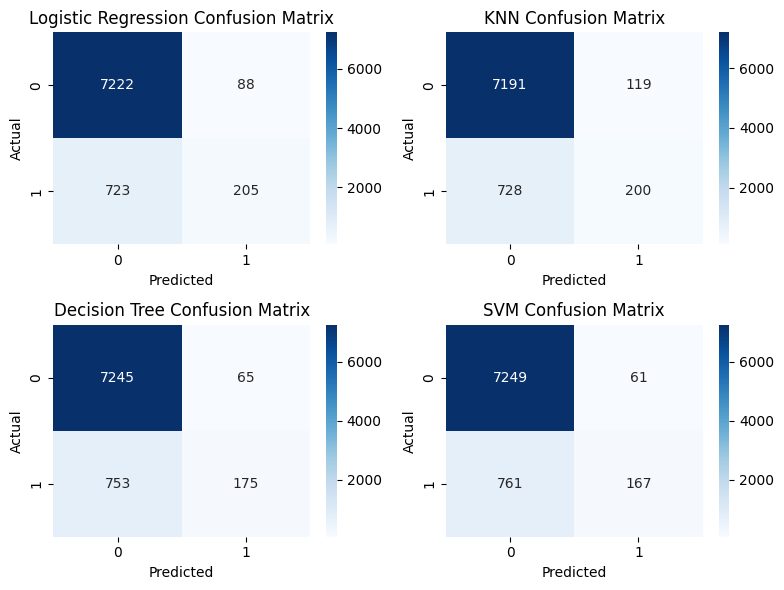

In [68]:
# Wrap models in pipelines
pipelines = {
    name: Pipeline([
        ('preprocessing', preprocessor),
        ('classifier', model)
    ]) for name, model in models.items()
}

# Fit pipelines
for pipeline in pipelines.values():
    pipeline.fit(X_train, y_train)

# Initialize storage for metrics
metrics_data = []

fig, axes = plt.subplots(2, 2, figsize=(8, 6))

for ax, (name, pipeline) in zip(axes.flatten(), pipelines.items()):
    y_pred = pipeline.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f"{name} Confusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    
    # Compute metrics
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    metrics_data.append({
        "Model": name,
        "Precision": round(precision, 2),
        "Recall": round(recall, 2),
        "F1-Score": round(f1, 2)
    })

plt.tight_layout()
plt.show()

In [69]:
# Create and display DataFrame
metrics_df = pd.DataFrame(metrics_data)
print(metrics_df)

                 Model  Precision  Recall  F1-Score
0  Logistic Regression       0.70    0.22      0.34
1                  KNN       0.63    0.22      0.32
2        Decision Tree       0.73    0.19      0.30
3                  SVM       0.73    0.18      0.29


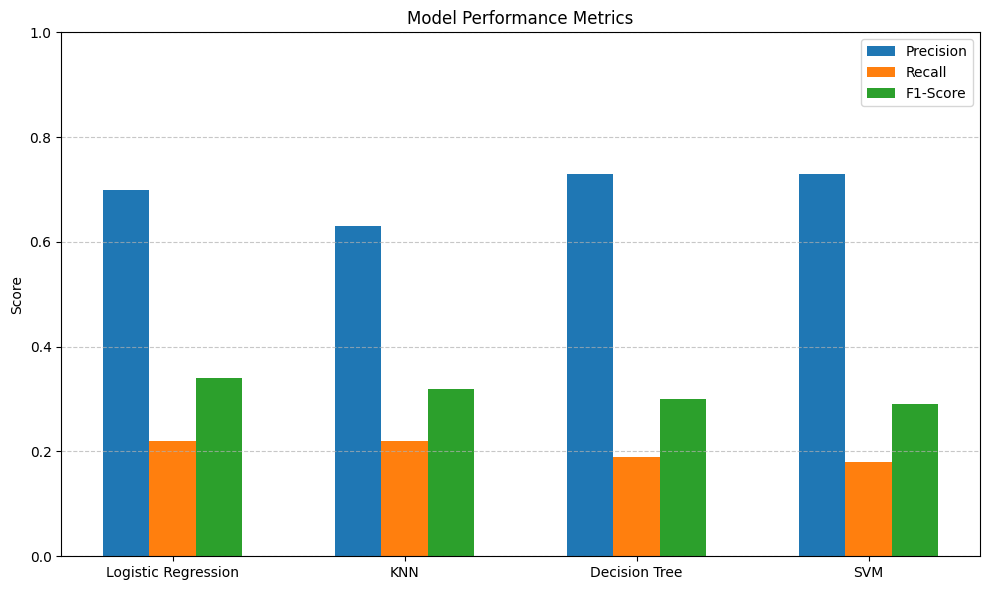

In [70]:
# Create DataFrame from metrics
df_metrics = pd.DataFrame(metrics_data)

# Set position and width for bars
x = range(len(df_metrics))
width = 0.2

# Plot
plt.figure(figsize=(10, 6))
plt.bar([i - width for i in x], df_metrics['Precision'], width=width, label='Precision')
plt.bar(x, df_metrics['Recall'], width=width, label='Recall')
plt.bar([i + width for i in x], df_metrics['F1-Score'], width=width, label='F1-Score')

# Labels and formatting
plt.xticks(x, df_metrics['Model'])
plt.ylabel('Score')
plt.title('Model Performance Metrics')
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()